In [1]:
import cv2
import numpy as np
from random import shuffle
import random
import tqdm
import os
import tensorflow as tf
import gc
import matplotlib.pyplot as plt
%matplotlib inline

IMAGE_SIZE = [299, 299]
EPOCHS = 10

VALIDATION_SPLIT = 0.20
CLASSES = ['normal', 'pneumonia'] # do not change, maps to the labels in the data (folder names)

/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/toni/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [2]:
train_dir = 'train_data'
test_dir = 'test_data'

train_normal = ['train_data/{}'.format(i) for i in os.listdir(train_dir) if 'NORMAL' in i] #get normal
train_pneumonia = ['train_data/{}'.format(i) for i in os.listdir(train_dir) if 'PNEUMONIA' in i] #get diseased

test_imgs = ['test_data/{}'.format(i) for i in os.listdir(test_dir)] #get test imgs

train_imgs = train_normal + train_pneumonia
random.shuffle(train_imgs)

del train_normal
del train_pneumonia
gc.collect()

15

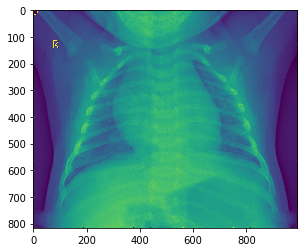

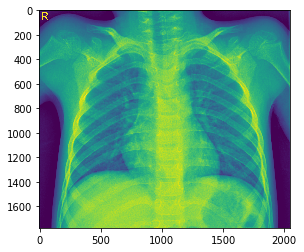

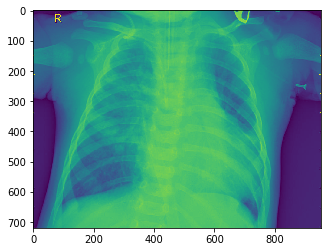

In [3]:
#show some imgs
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    implot=plt.imshow(img)
    plt.show()

In [4]:
#declare img dims
nrows = 299
ncols = 299
channels = 3

def read_and_process_image(list_of_images):
    """
    Returns two arrays:
        X is an array of resized imgs
        y is an array of labels
    """
    X = []
    y = []
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncols), interpolation=cv2.INTER_CUBIC))
        if 'NORMAL' in image:
            y.append(0)
        elif 'PNEUMONIA' in image:
            y.append(1)
            
    return X, y

In [5]:
X, y = read_and_process_image(train_imgs)

In [6]:
#preview X
X[0]

array([[[ 39,  39,  39],
        [255, 255, 255],
        [ 33,  33,  33],
        ...,
        [ 32,  32,  32],
        [ 31,  31,  31],
        [ 30,  30,  30]],

       [[203, 203, 203],
        [  4,   4,   4],
        [  0,   0,   0],
        ...,
        [ 33,  33,  33],
        [ 32,  32,  32],
        [ 30,  30,  30]],

       [[253, 253, 253],
        [  2,   2,   2],
        [  0,   0,   0],
        ...,
        [ 34,  34,  34],
        [ 30,  30,  30],
        [ 29,  29,  29]],

       ...,

       [[ 20,  20,  20],
        [ 19,  19,  19],
        [ 23,  23,  23],
        ...,
        [ 13,  13,  13],
        [  9,   9,   9],
        [ 12,  12,  12]],

       [[ 25,  25,  25],
        [ 16,  16,  16],
        [ 19,  19,  19],
        ...,
        [ 11,  11,  11],
        [ 18,  18,  18],
        [  0,   0,   0]],

       [[  1,   1,   1],
        [ 17,  17,  17],
        [ 17,  17,  17],
        ...,
        [  9,   9,   9],
        [ 16,  16,  16],
        [  0,   0,   0]]

In [7]:
#preview Y
y[0:10]

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1]

AttributeError: module 'matplotlib.pyplot' has no attribute 'label'

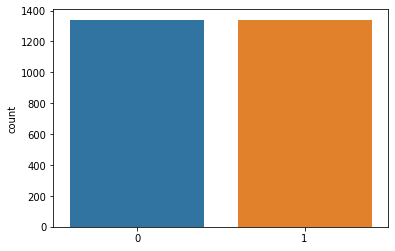

In [8]:
import seaborn as sns
del train_imgs
gc.collect()

#Convert lists
X = np.array(X)
y = np.array(y)

sns.countplot(y)
plt.label('Labels for Normal and Pneumonia')


In [9]:
print("Shape of train images is: ", X.shape)
print("Shape of train labels is: ", y.shape)

Shape of train images is:  (2682, 299, 299, 3)
Shape of train labels is:  (2682,)


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20, random_state=2)

print("Shape of train images is: ", X_train.shape)
print("Shape of test images is: ", X_val.shape)

print("Shape of labels is: ", y_train.shape)
print("Shape of labels is: ", y_val.shape)

Shape of train images is:  (2145, 299, 299, 3)
Shape of test images is:  (537, 299, 299, 3)
Shape of labels is:  (2145,)
Shape of labels is:  (537,)


In [11]:
del X
del y
gc.collect()

ntrain = len(X_train)
nval= len(X_val)

batch_size = 64

In [12]:
from keras.models import  Sequential
from keras.layers import  *
from keras.optimizers import  *
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [13]:
pretrained_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 262146    
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
train_datagen = ImageDataGenerator(rescale=1./299)
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)

test_datagen = ImageDataGenerator(rescale=1./299)
test_generator = test_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=ntrain // batch_size, epochs=EPOCHS, validation_data=test_generator,
                             validation_steps=nval // batch_size)

Epoch 1/10
33/33 [==============================] - 140s 4s/step - loss: 1.7803 - acc: 0.8582 - val_loss: 12.7166 - val_acc: 0.4844
Epoch 2/10
10/33 [========>.....................] - ETA: 1:20 - loss: 0.6666 - acc: 0.9328

In [ ]:
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+ 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [ ]:
# FINALLY LETS PREDICT
X_test, y_test = read_and_process_image(test_imgs[0:10])
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./299)

In [ ]:
i=0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    print(pred[0])
    if pred.any() > 0.5:
        text_labels.append('PNEUMONIA')
    else:
        text_labels.append('NOTHING')
    plt.subplots(1,1 , 'col')
    plt.title('This patient has'+ text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()